# 1C: Setting state in the fortran model from Python

In this notebook we will illustrate how you can use the `fv3gfs.wrapper.set_state` method to modify the state of variables in the fortran model.

We'll start with some of the same boilerplate code from before.

## Recursively copy the contents of the example run directory to a clean folder in the docker container

We'll also override the input namelist of the reference run directory.

In [1]:
import os
import shutil

In [2]:
REFERENCE = "reference_rundir"
RUNDIR = "rundir_3"

if os.path.isdir(RUNDIR):
    shutil.rmtree(RUNDIR)
shutil.copytree(REFERENCE, RUNDIR);

## Start the ipyparallel session for the notebook

This involves running a couple shell commands (hence the `%%bash` cell magic command at the top of the following cell); note this means these commands are executed in the shell rather than the notebook.

In [3]:
%%bash
# if you get a crash, add --debug to this command to put more info in logs
# logs are in /root/.ipython/profile_mpi/log
ipcluster start --profile=mpi -n 6 --daemonize
sleep 10  # command is asynchronous, so let's wait to avoid an error in the next cell

In [4]:
import ipyparallel as ipp
rc = ipp.Client(profile='mpi', targets='all', block=True)
dv = rc[:]
dv.activate()
dv.block = True

In [5]:
print("Running IPython Parallel on {0} MPI engines".format(len(rc.ids)))
print("Commands in the following cells will be executed in parallel (disable with %autopx)")
%autopx

Running IPython Parallel on 6 MPI engines
Commands in the following cells will be executed in parallel (disable with %autopx)
%autopx enabled


## Use `mpi4py` gain access to the communicator for the notebook.

In [6]:
from mpi4py import MPI

comm = MPI.COMM_WORLD
mpi_size = comm.size
mpi_rank = comm.rank

## Enter the run directory

Next we move into the run directory we created.  Note that we need to re-import `os` and re-define any variables we created before we started the cluster.  `fv3gfs.wrapper` requires that its routines are called from within a valid run directory.

In [7]:
import os
RUNDIR = "rundir_3"
os.chdir(RUNDIR)

## Setting the fortran state of the model

To be able to truly modify the main time-stepping loop of the model (beyond just in a diagnostic sense) requires being able to modify the state of fortran variables themselves.  fv3gfs-wrapper offers a way of doing this through the `wrapper.set_state` function.  It takes in a state (a dictionary mapping variable names to `Quantity` objects) as an argument and will update the corresponding fortran variables.  Any variable you can "get" is a variable you can also "set."

To illustrate this, we'll go through a few examples.

## Converting all water vapor to rain

An extreme example we can use to illustrate the `set_state` capability of the model is to take all water vapor in the atmosphere and convert it immediately to rain water.  We'll leverage the `mass_weighted_integral` function we defined in the `get_state` notebook to illustrate that things worked as expected.

As usual, we'll start by initializing the model.  We'll plot the column-integrated water vapor and rain water to show their initial values.

In [8]:
import fv3gfs.util
import numpy as np

from fv3gfs import wrapper
from tools import plot_global

In [9]:
wrapper.initialize()

In [10]:
state = wrapper.get_state([
    "specific_humidity",
    "rain_mixing_ratio",
    "pressure_thickness_of_atmospheric_layer"
])

In [11]:
GRAVITY = 9.81

def mass_weighted_integral(q, delp):
    integral = (q.view[:] * delp.view[:]).sum(axis=0) / GRAVITY
    return fv3gfs.util.Quantity(integral, q.dims[1:], units="kg/m**2")

In [12]:
column_water_vapor = mass_weighted_integral(
    state["specific_humidity"],
    state["pressure_thickness_of_atmospheric_layer"]
)
column_rain_water = mass_weighted_integral(
    state["rain_mixing_ratio"],
    state["pressure_thickness_of_atmospheric_layer"]
)

[output:0]

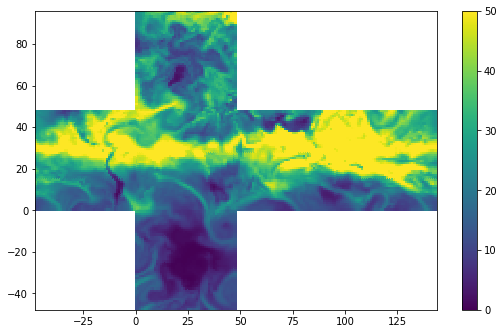

In [13]:
plot_global(column_water_vapor, comm, 0, 50)

[output:0]

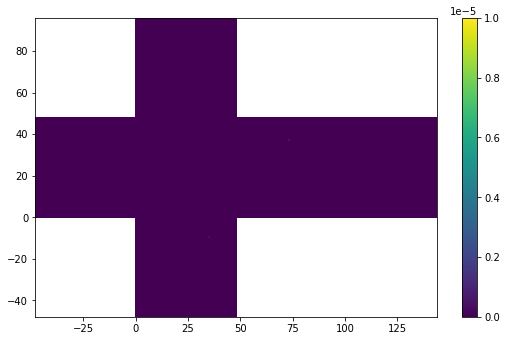

In [14]:
plot_global(column_rain_water, comm, 0, 0.00001)

Upon initialization there is no rain water in the atmosphere.  Let's run the model a timestep to fill this variable with some physical values.

In [15]:
wrapper.step_dynamics()
wrapper.step_physics()

In [16]:
state = wrapper.get_state([
    "specific_humidity",
    "rain_mixing_ratio",
    "pressure_thickness_of_atmospheric_layer"
])
column_rain_water = mass_weighted_integral(state["rain_mixing_ratio"], state["pressure_thickness_of_atmospheric_layer"])

Now we have some more physical values for column rain water.

[output:0]

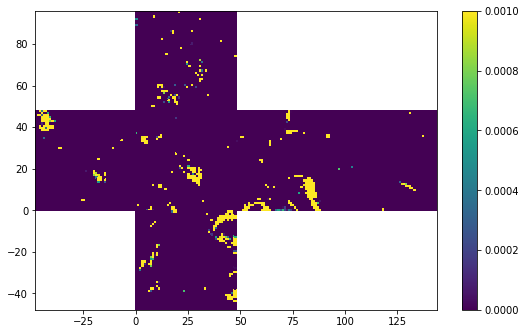

In [17]:
plot_global(column_rain_water, comm, 0, 0.001)

To illustrate setting the state of the model, we'll convert all the water vapor to rain, and then plot the state of the column water vapor and column rain water.  In the cell before the last, we got the state of the two tracers we need (`"specific_humidity"` and `"rain_mixing_ratio"`).  We can create an updated state dictionary where `"specific_humidity"` is zero and `"rain_mixing_ratio"` is `"rain_mixing_ratio"` plus `"specific_humidity"`.

In [18]:
def zeros_like(quantity):
    return fv3gfs.util.Quantity(
        np.zeros(quantity.data.shape),
        dims=quantity.dims,
        units=quantity.units,
        extent=quantity.extent,
        origin=quantity.origin
    )


def add(*quantities):
    """Arithmetic is currently not supported directly on Quantity objects"""
    units = quantities[0].units
    assert all(quantity.units == units for quantity in quantities), "To be added, all quantities must have same units"
    result = sum([quantity.data_array for quantity in quantities]).assign_attrs(units=units)
    return fv3gfs.util.Quantity.from_data_array(result)


updated_state = {
    "specific_humidity": zeros_like(state["specific_humidity"]),
    "rain_mixing_ratio": add(state["specific_humidity"], state["rain_mixing_ratio"])
}

Now we can set the state with the updated values.  Note by construction of this example, the mass of water species in the atmosphere has not changed.

In [19]:
wrapper.set_state(updated_state)

To show this worked, let's get the state of these variables from the fortran model again.

In [20]:
state = wrapper.get_state([
    "specific_humidity",
    "rain_mixing_ratio",
    "pressure_thickness_of_atmospheric_layer"
])
column_water_vapor = mass_weighted_integral(state["specific_humidity"], state["pressure_thickness_of_atmospheric_layer"])
column_rain_water = mass_weighted_integral(state["rain_mixing_ratio"], state["pressure_thickness_of_atmospheric_layer"])

[output:0]

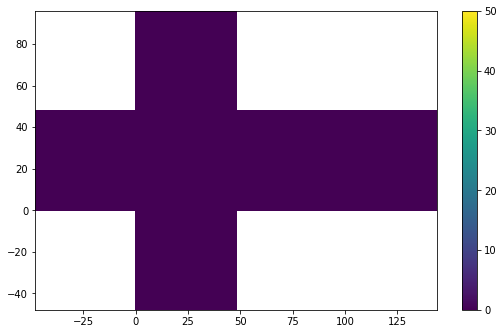

In [21]:
plot_global(column_water_vapor, comm, 0, 50)

[output:0]

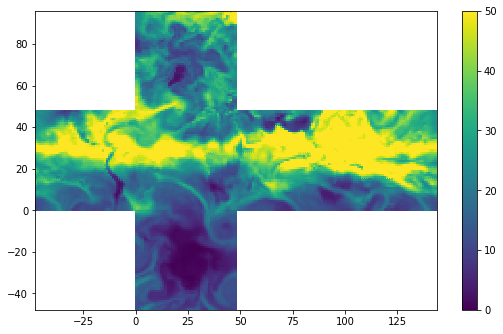

In [22]:
plot_global(column_rain_water, comm, 0, 50)

We can now run the model forward a timestep and see how much of the rain falls and how much the specific humidity and cloud liquid water recover from being all rained out.

In [23]:
wrapper.step_dynamics()
wrapper.step_physics()

In [24]:
state = wrapper.get_state([
    "specific_humidity",
    "rain_mixing_ratio",
    "pressure_thickness_of_atmospheric_layer"
])
column_water_vapor = mass_weighted_integral(state["specific_humidity"], state["pressure_thickness_of_atmospheric_layer"])
column_rain_water = mass_weighted_integral(state["rain_mixing_ratio"], state["pressure_thickness_of_atmospheric_layer"])

[output:0]

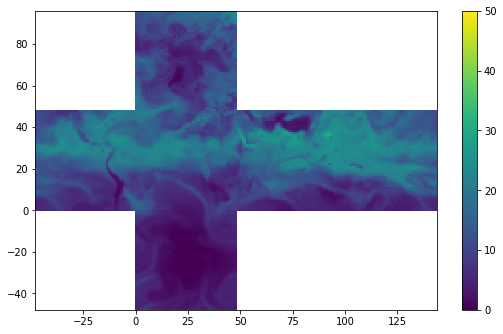

In [25]:
plot_global(column_water_vapor, comm, 0, 50)

[output:0]

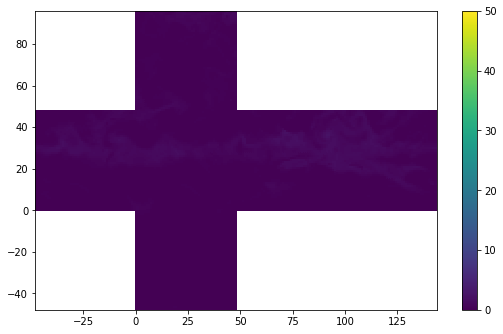

In [26]:
plot_global(column_rain_water, comm, 0, 50)

## Dry air mass conservation

FV3GFS, in its default configuration, approximately conserves the mass of dry air.  We can show this by running the model and tracking the total mass of dry air after each timestep.  This is a little bit involved, but it may be instructive to go through how one might compute a diagnostic, in this case global dry air mass, that is a reduction across all MPI ranks.

Total air mass in FV3GFS is defined as the mass of dry air plus the mass of all water tracers. In our configuration, there are six water species: specific humidity, cloud liquid water, cloud ice water, rain water, snow water, and graupel.  We can compute the total mass of air by doing a global sum of $\frac{A \Delta p}{g}$.  Here $\Delta p$ is the pressure thickness of the atmospheric layers, $A$ is the grid cell area, and $g$ is the gravitational acceleration.  The total mass of a tracer $q$ is very similar; it is global sum of $\frac{q A \Delta p}{g}$.

As such, the total mass of dry air can be defined as:

$$ \sum_{domain} \frac{A \Delta p}{g} - \sum_{domain} \sum_{t}^{n_{wat}} \frac{q_t A \Delta p}{g} = \sum_{domain} \frac{A \Delta p}{g} \left(1 - \sum_t^{n_{wat}} q_t \right) = \sum_{domain} \frac{q_d A \Delta p}{g}$$

On the far right hand side $q_d$ is the "dry air mixing ratio," defined as one minus the sum of the water species mixing ratios.

In [27]:
def full_like(quantity, fill_value):
    return fv3gfs.util.Quantity(
        np.full(quantity.data.shape, fill_value),
        dims=quantity.dims,
        units=quantity.units,
        extent=quantity.extent,
        origin=quantity.origin
    )


def ones_like(quantity):
    return fv3gfs.util.Quantity(
        np.ones(quantity.data.shape),
        dims=quantity.dims,
        units=quantity.units,
        extent=quantity.extent,
        origin=quantity.origin
    )


def multiply(*quantities, units="unknown"):
    result = 1.0
    for quantity in quantities:
        result *= quantity.data_array
    return fv3gfs.util.Quantity.from_data_array(result.assign_attrs(units=units))


def get(variable):
    return wrapper.get_state([variable])[variable]


def global_integral(communicator, q):
    delp = get("pressure_thickness_of_atmospheric_layer")
    area = get("area_of_grid_cell")
    one_over_gravity = fv3gfs.util.Quantity(np.array(1 / GRAVITY), dims=[], units="s**2/m")
    total_mass_on_rank = multiply(q, delp, area, one_over_gravity).view[:].sum()

    global_sum = np.array(0.0)
    communicator.Reduce(total_mass_on_rank, global_sum, root=0, op=MPI.SUM)
    return global_sum.item()

In [28]:
def total_water_mixing_ratio():
    water_species = [tracer for tracer, metadata in wrapper.get_tracer_metadata().items() if metadata["is_water"]]
    state = wrapper.get_state(water_species)
    return add(*[state[tracer] for tracer in water_species])


def dry_air_mixing_ratio():
    template = wrapper.get_state(["specific_humidity"])["specific_humidity"]
    total_water = total_water_mixing_ratio()
    return add(
        ones_like(template),
        multiply(full_like(template, -1.0), total_water_mixing_ratio(), units="kg/kg")
    )


def dry_air_mass(communicator):
    return global_integral(communicator, dry_air_mixing_ratio())

In [29]:
dry_air_mass(comm)

Out[0:24]: 5.096095433838973e+18

Out[1:24]: 0.0

Out[2:24]: 0.0

Out[3:24]: 0.0

Out[4:24]: 0.0

Out[5:24]: 0.0

In [30]:
mass = []
for i in range(10):
    wrapper.step_dynamics()
    wrapper.step_physics()
    mass.append(dry_air_mass(comm))

[output:0]

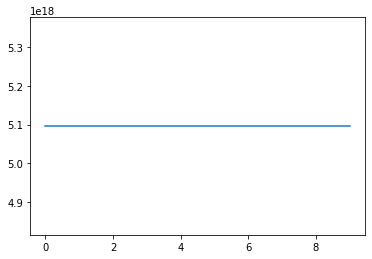

In [31]:
import matplotlib.pyplot as plt
if comm.rank == 0: plt.plot(mass)

Something to we should keep in mind when updating the state of tracer masses in particular is that the pressure thickness -- an important prognostic variable in the non-hydrostatic version of the model -- is defined using the mass of dry air plus all water species.  Therefore if one updates the total mass of water species in any way, one should also update the pressure thickness in the dynamical core.  We sidestepped this issue in the example above, because we simply shifted mass from one water species to another.  

## Exercise:

What happens to the dry air mass if we set the specific humidity tracer to zero in each timestep and do not modify the pressure thickness?  As we did in the example just above, step the model forward ten timesteps, but at the end of each timestep set the state of the specific humidity to zero, without adding it to any other water vapor tracer.  Then compute and track the global dry air mass.  Plot the time series of the global dry air mass.

In [32]:
mass = []
for i in range(10):
    wrapper.step_dynamics()
    wrapper.step_physics()
    state = wrapper.get_state(["specific_humidity"])
    state["specific_humidity"].view[:] = 0.0
    wrapper.set_state(state)
    mass.append(dry_air_mass(comm))

[output:0]

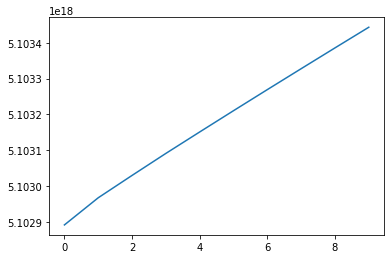

In [33]:
if comm.rank == 0: plt.plot(mass)

The mass of dry air steadily increases, because we are removing water but holding the pressure thickness approximately constant.

## Using `set_state_mass_conserving`

fv3gfs-wrapper has a convenience function that does the necessary book-keeping to ensure that dry air mass is conserved when updating any water tracer values; this is the `set_state_mass_conserving` function.  It operates the same way as the `set_state` function -- and can be used even for non-water-tracer variables -- but has added safety.  

Swap `set_state_mass_conserving` in for `set_state` in the code from your work above and plot the time series of dry air mass again.

In [34]:
mass = []
for i in range(10):
    wrapper.step_dynamics()
    wrapper.step_physics()
    state = wrapper.get_state(["specific_humidity"])
    state["specific_humidity"].view[:] = 0.0
    wrapper.set_state_mass_conserving(state)
    mass.append(dry_air_mass(comm))

[output:0]

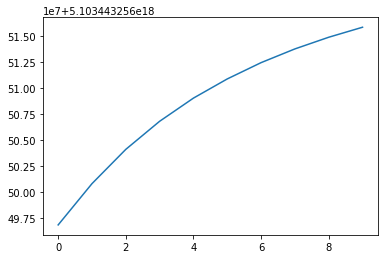

In [35]:
if comm.rank == 0: plt.plot(mass)

While not perfect, we can see that we do a much better job of conserving dry air mass when using `set_state_mass_conserving`.  Errors are in the 10^-8 percent of global dry air mass.

# Other possible exercises

- Removing specific humidity from the atmosphere by converting it all to rain is already not very physical, but perhaps make it slightly more physical by adding in the effect of the latent heat release that condensing all that water vapor would cause.  In other words, in addition to shifting the water vapor to rain water as we did in the first example, increase the temperature by an increment equal to $\Delta T = \frac{L_v \Delta q_v}{C_v}$, where $\Delta T$ is the temperature increment, $L_v$ is the latent heat of vaporization (approximately 2.5 x 10^6 J/kg), $q_v$ is the specific humidity, and $C_v$ is the specific heat of air at constant volume.  For the purposes of this exercise feel free to use the specific heat of dry air at constant volume at a single temperature for simplicity (i.e. approximately 717 J/kg K); if you wanted to be more thorough, however, you could compute a moist specific heat of air at constant volume that depended on tracer concentrations.

## Latent heating

In [36]:
one_over_Cv = fv3gfs.util.Quantity(np.array(1 / 717.), dims=[], units="kg K/J")
Lv = fv3gfs.util.Quantity(np.array(2.5e6), dims=[], units="J/kg")


def condense_all_water_vapor_to_rain():
    state = wrapper.get_state(["air_temperature", "specific_humidity", "rain_mixing_ratio"])
    latent_heating = multiply(state["specific_humidity"], Lv, one_over_Cv, units="degK")
    state["air_temperature"] = add(latent_heating, state["air_temperature"])
    state["rain_mixing_ratio"] = add(state["rain_mixing_ratio"], state["specific_humidity"])
    state["specific_humidity"] = zeros_like(state["specific_humidity"])
    
    # We'll use set_state_mass_conserving for good measure, even though we would
    # not expect it to be an issue here.
    wrapper.set_state_mass_conserving(state)

In [37]:
for i in range(4):
    wrapper.step_dynamics()
    wrapper.step_physics()
    condense_all_water_vapor_to_rain()